In [30]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import pandas as pd
import seaborn as sns
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms



In [31]:
# Rutas correctas a los archivos en OneDrive
train_path = "/Users/linaavilamoreno/Library/CloudStorage/OneDrive-Personal/Documentos/Alzheimer/Data/train-00000-of-00001-c08a401c53fe5312.parquet"
test_path = "/Users/linaavilamoreno/Library/CloudStorage/OneDrive-Personal/Documentos/Alzheimer/Data/test-00000-of-00001-44110b9df98c5585.parquet"

# Cargar los datasets
train_df = pd.read_parquet(train_path, engine="pyarrow")
test_df = pd.read_parquet(test_path, engine="pyarrow")

# Mostrar información básica
print("Train Dataset:")
print(train_df.info())
print(train_df.head())

print("\nTest Dataset:")
print(test_df.info())
print(test_df.head())

Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB
None
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2

Test Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1280 non-null   object
 1   label   1280 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB
Non

In [32]:
print(train_df.head())  
print(train_df.columns)  #Columnas disponibles


                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
Index(['image', 'label'], dtype='object')


In [33]:
print(type(train_df["image"].iloc[0]))


<class 'dict'>


In [42]:
print(test_df.shape)
print(test_df.head())


(1280, 2)
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0


In [ ]:
Realizaremos una función que pase de un diccionario que contenga una llave llamada bytes, 

In [35]:
def dict_to_image(image_dict):
    #Verifica si image_dict es efectivamente un diccionario.
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        #Si la validación pasa, se toma el valor correspondiente a la clave 'bytes'. 
        #Este valor debería ser una cadena de bytes que representa una imagen codificada.
        byte_string = image_dict['bytes']
        
        #Convierte la cadena de bytes en un arreglo de tipo NumPy usando el tipo de dato uint8
        nparr = np.frombuffer(byte_string, np.uint8)

        #Decodifica el arreglo NumPy (nparr) y lo convierte en una imagen.
        #No usamos los tres canales RGB sino escala de grises
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

In [36]:
train_df['img_arr'] = train_df['image'].apply(dict_to_image)
train_df.drop("image", axis=1, inplace=True)
train_df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [43]:
test_df['img_arr'] = test_df['image'].apply(dict_to_image)
test_df.drop("image", axis=1, inplace=True)
test_df.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
Visualización de las imagenes convertidas.

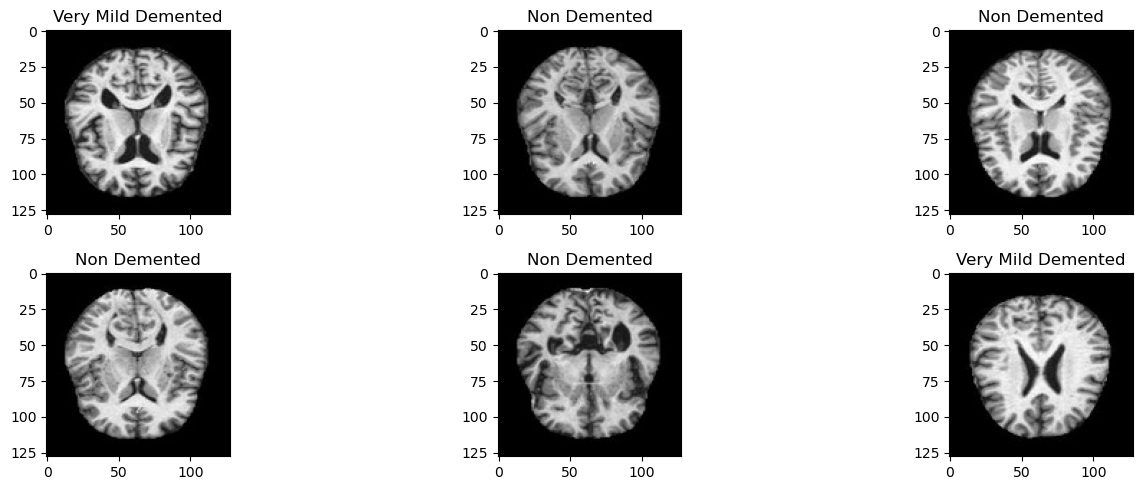

In [57]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(train_df))
    axes.imshow(train_df.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label_from_category[train_df.iloc[rand]['label']])
plt.tight_layout()
plt.show()

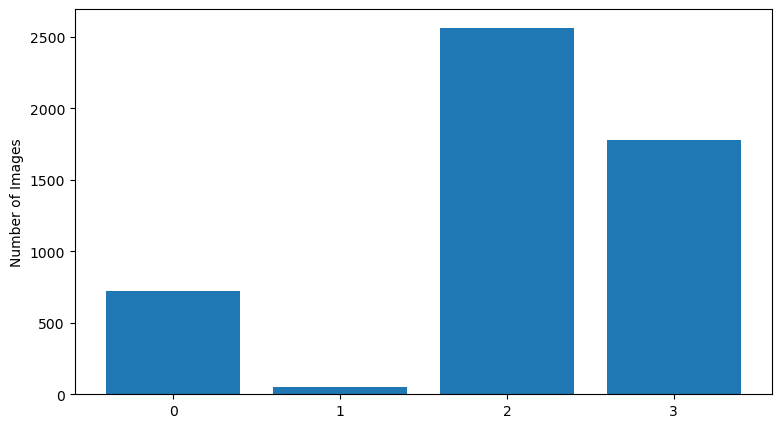

Total muestras en el conjunto de datos= 5120


In [73]:
plt.figure(figsize=(9, 5))
plt.bar(np.arange(0, 4, 1), train_df['label'].value_counts().sort_index())
plt.ylabel("Number of Images")
plt.xticks(np.arange(0, 4, 1))
labels=([disease_label_from_category[i] for i in range(4)])
plt.show()
print(f"Total muestras en el conjunto de datos= {len(train_df)}")

In [ ]:
Convertir las etiquetas en clases binarias, donde:
- Non-Demented (Healthy): Label como 0.
- Demented: Label como 1, (Very Mild, Mild, y Moderate Demented).

In [80]:
label_mapping = {
    0: 1,  
    1: 1,  
    2: 0,  
    3: 1   
}
class AlzheimerBinaryDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # Copia del DataFrame para evitar modificar el original
        self.dataframe = dataframe.copy()

        # Verificar si la columna 'label' existe antes de mapear
        if "label" not in self.dataframe.columns:
            raise KeyError("La columna 'label' no existe en el DataFrame.")
        
        print("Etiquetas únicas antes mapping:", self.dataframe["label"].unique())

        # Aplicar el mapeo binario a los labels
        self.dataframe["label"] = self.dataframe["label"].map(label_mapping)

        # Verificar que los labels sean solo 0 o 1
        unique_labels = self.dataframe["label"].unique()
        if not all(label in [0, 1] for label in unique_labels):
            raise ValueError(f"Unexpected label values found after mapping: {unique_labels}")

        # Verificar si la columna 'img_arr' existe
        if "img_arr" not in self.dataframe.columns:
            raise KeyError("La columna 'img_arr' no existe en el DataFrame.")

        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Obtener la imagen y la etiqueta
        image = self.dataframe.iloc[idx]["img_arr"]
        label = self.dataframe.iloc[idx]["label"]

        # Convertir a tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, height, width)
        label = torch.tensor(label, dtype=torch.long)

        # Aplicar transformaciones si existen
        if self.transform:
            image = self.transform(image)

        return image, label

In [82]:
# Definir la transformación correctamente
transform = transforms.Compose([
    transforms.Resize((28, 28)),             # Redimensionar a 28x28
    transforms.Normalize((0.5,), (0.5,))     # Normalizar a rango [-1, 1]
])

# Inicializar el dataset con la transformación corregida
binary_dataset = AlzheimerBinaryDataset(train_df, transform=transform)

# Ver un ejemplo
sample_image, sample_label = binary_dataset[0]
print("Sample image shape:", sample_image.shape)  # Debe ser (1, 28, 28)
print("Etiqueta de muestra (binary):", sample_label)


Etiquetas únicas antes mapping: [2 0 3 1]
Sample image shape: torch.Size([1, 28, 28])
Etiqueta de muestra (binary): tensor(0)
